# Why model?

What is the purpose of a model?
* to predict system behaviour before experiments
* to investigate which parameter values lead to behaviour you want
* to make your understanding concrete and not hand-wavy
* etc etc.

Your reasons for modelling should be clear from the start! Because models are imperfect 'representations of reality'. You have to know when your model has achieved its function, and hence when to stop.


# Outline for today
* First an introduction to ODEs

* Modelling, step-by-step, with an introduction to tools:
1. Mechanism
2. ODEs
3. Prediction
4. Inference

* Basic TXO model for *you* to improve
* Strategy for iGEM

# Part 1: What is an ODE?

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.integrate import odeint

A differential equation relates the **value of a function** to its **rate of change**:

\begin{equation}
\frac{dp(t)}{dt} = -k p(t)
\end{equation}

Here, $p(t)$ is a time-dependent variable, and $k$ is a constant parameter. This equation can also be expressed using dot-notation as $\dot{p}=-kp$.

This equation says that the rate of change of $p(t)$, as a function of $t$, is equal to 
* the value of p(t)
* scaled by the parameter k
* with a minus sign

So, 
1. when $p$ is large, the gradient is steep and downwards
2. when $p$ is small, the gradient is shallow and close to 0.

Let's solve the equation to see if this intuition is correct.

## 1. Solving the equation mathematically

To mathematically solve this equation, we **integrate**:

\begin{equation}
\frac{dp(t)}{dt} = -k p(t)
\end{equation}

\begin{equation}
dp(t) = -k p(t) dt
\end{equation}

\begin{equation}
\int dp = \int -k p(t) dt
\end{equation}

\begin{equation}
\int \frac{dp}{p(t)} = \int -k dt
\end{equation}

### 1.1 Indefinite integration: a family of functions

We can integrate *indefinitely*, which means solving the equation generally, which results in a family of functions (as multiple functions can obey the same ODE):

\begin{equation}
\int \frac{dp}{p(t)} = \int -k dt
\end{equation}
which, using standard integration results, becomes:
\begin{equation}
\ln p(t) = -kt + C
\end{equation}
where $C$ is a *constant of integration*. This can be expressed as:
\begin{equation}
p(t) = \exp(-kt + C)
\end{equation}
\begin{equation}
p(t) = \exp(-kt)\exp(C)
\end{equation}
\begin{equation}
p(t) = A\exp(-kt),
\end{equation}
where we have redefined $A=\exp(C)$ as a new constant of integration. What does this look like?

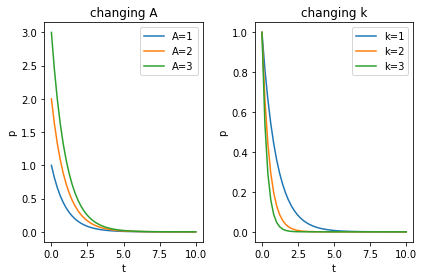

In [2]:
# Plot 

t = np.linspace(0,10,50)

def p(t,k,A):
    return A*np.exp(-k*t)

f, (ax1, ax2) = plt.subplots(1, 2)
for A in [1,2,3]:
    k = 1
    ax1.plot(t, p(t,k,A), label='A='+str(A))
ax1.set_title('changing A'); ax1.legend(); ax1.set_xlabel('t'); ax1.set_ylabel('p')

for k in [1,2,3]:
    A = 1
    ax2.plot(t,p(t,k,A), label='k='+str(k))
ax2.set_title('changing k') ; ax2.legend(); ax2.set_xlabel('t'); ax2.set_ylabel('p')
f.tight_layout(); plt.show()

So our intuition was correct. Additionally you can see how the constants $A$ and $k$ affect the solution: $A$ is the y-intercept, which in this case is also known as the *initial condition*, as it represents the value of $p$ at time $t=0$. $k$ is the decay constant. In general, this family of solutions represents an exponential decay.

### 1.2 Definite integration: a specific case

We can also carry out *definite integration*, which means solving the equation for a specific case. Here you need **boundary conditions**, which are values of the function at specific times: this allows you to select your trajectory out of the large family of possible trajectories illustrated above. 

For instance, say you knew that $p(t=0)$ equals some constant $p_0$:

\begin{equation}
\int_{p=p_0}^{p(t)} \frac{dp}{p(t)} = \int_{0}^{t=\infty} -k dt
\end{equation}
As before we end up with the standard integration result, but this time without an integration constant:
\begin{equation}
\left[\ln p(t)\right]_{p_0}^{p} = \left[-kt\right] _{0}^{t}
\end{equation}
which becomes, after evaluating the brackets at each of the time points,

\begin{equation}
\ln p(t) - \ln p_0 = -kt - 0
\end{equation}

\begin{equation}
p(t) = \exp(-kt + \ln p_0)
\end{equation}
\begin{equation}
p(t) = p_0\exp(-kt),
\end{equation}
where we now get a specific trajectory (equivalent to above, but with $A=p_0$, our boundary condition).

## 2. Solving the equation numerically

In the computer we would like to solve this equation numerically. To do this we use the definition of the derivative, that $dt\approx\Delta t$, and $dp(t)\approx(p(t+\Delta t)-p(t))$:
\begin{equation}
\frac{dp(t)}{dt} = -k p(t)
\end{equation}
becomes
\begin{equation}
\frac{p(t+\Delta t)-p(t)}{\Delta t} = -k p(t)
\end{equation}

So we can rearrange this to get

\begin{equation}
p(t+\Delta t) = (-k p(t))\Delta t+p(t)
\end{equation}

This equation gives $p(t+\Delta t)$, the value of $p$ at the next time increment, calculating it from $p$ at the previous time step. So by iterating over this equation, starting from an initial value of $p$, we can determine all future values of $p$. This way of solving is called the *Euler method* and forms the basis of all numerical ODE solvers. 

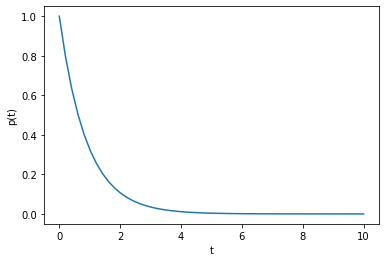

In [3]:
# Euler method with python

def euler(p0, t, k):
    
    dt = t[1]-t[0] # time increment
    N = len(t) # number of timepoints
    p = np.ones(N)*p0

    for j in range(N-1):
        p[j+1] = -k*p[j]*dt + p[j]
        
    return(p)

time = np.linspace(0,10,50)
p0 = 1.0
k = 1
p = euler(p0,time,k)
plt.plot(time,p); plt.xlabel('t'); plt.ylabel('p(t)'); plt.show()

In python we can use the more efficient `odeint` function from scipy. This function takes as an input
* initial values for all dependent variables (in this case, p)
* the axis of independent variables (in this case, t)
* parameters (in this case, k)
* and a function which returns the gradient i.e. the differential equation to be solved.

See below for how it's done:

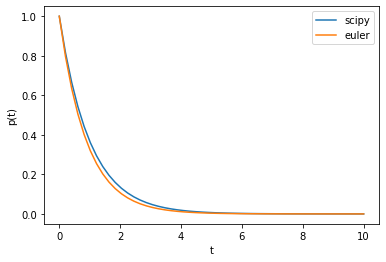

In [4]:
# Standard script to solve ODEs

time = np.linspace(0,10,50)
p0 = 1.0
params = np.array([1.0])

def grads(y, t, params):
    p = y[0]    
    k = params[0]
   
    derivs = [
        -k*p
    ]
    return(derivs)

sol = odeint(grads, p0, time, args=(params,)) # The most important line! 

plt.plot(time,sol, label='scipy'); plt.xlabel('t'); plt.ylabel('p(t)'); 
plt.plot(time,euler(p0,time,params), label='euler'); plt.legend(); plt.show() # compare to our Euler method

# Part 2: Modelling step-by-step

## 1. Mechanism

\begin{equation}
E + S \underset{k_{2}}{\stackrel{k_1}{\rightleftharpoons}} ES \overset{k_3}\rightarrow P + E
\end{equation}

can be broken down into the following elementary reactions

\begin{align}
S + E \overset{k_1}\rightarrow ES,\;\;\;\;\; &v_0 = k_1S\times E \\
ES \overset{k_2}\rightarrow S + E,\;\;\;\;\; &v_1 = k_2ES  \\
ES \overset{k_3}\rightarrow P + E,\;\;\;\;\; &v_2 = k_3ES 
\end{align}

which involves 4 species
\begin{align}
E \\
S \\
ES \\
P
\end{align}

and 3 parameters
\begin{align}
k_1 \\
k_2 \\
k_3 
\end{align}

## 2. ODEs

To make ODEs we have to figure out which which reactions produce and consume each species:

\begin{align}
\dot{e} &= -v_0 + v_1 + v_2\\
\dot{s} &= -v_0 + v_1 \\
\dot{x} &= v_0 - v_1 - v_2 \\
\dot{p} &= v_2
\end{align}

which becomes

\begin{align}
\dot{e} &= -k_1se + k_{2}x + k_3x\\
\dot{s} &= -k_1se + k_{2}x \\
\dot{x} &= k_1se - k_{2}x - k_3x \\
\dot{p} &= k_3x
\end{align}

## 3. Prediction

i.e. solving the ODEs, plotting and saving the results.

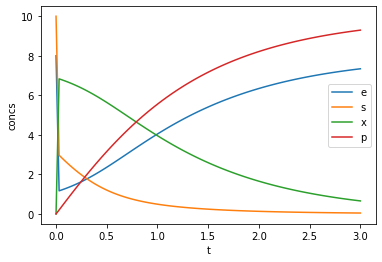

In [5]:
PATH_TO_MODELS = "./TXOsim/models/"
PATH_TO_OUTPUT = "./TXOsim/output/" # Path for output data, plots
MODELNAME = "MM"
MODELPY = "MM.py"
FILENAME = "MM.csv" # Filename for output data

time = np.linspace(0,3,100)

# Define initial conditions
e0 = 8.0
s0 = 10.0
x0 = 0.0
p0 = 0.0

# Define parameters
k1 = 100.0
k2 = 50.0
k3 = 1.0

# Set parameters and initial conditions in arrays
y0 = np.array([e0,s0,x0,p0])
params = np.array([k1,k2,k3])

# Define gradient function - our ODEs
def grads(y, t, params):
    e = y[0]
    s = y[1]
    x = y[2]
    p = y[3]
    
    k1 = params[0]
    k2 = params[1]
    k3 = params[2]
   
    derivs = [
        -k1*s*e + k2*x + k3*x,
        -k1*s*e + k2*x,
        k1*e*s - k2*x - k3*x,
        k3*x
    ]
    return(derivs)

# Solve the ODEs
sol = odeint(grads, y0, time, args=(params,))  # The most important line! 

# Plot the results
plt.plot(time,sol[:,0], label='e');
plt.plot(time,sol[:,1], label='s');
plt.plot(time,sol[:,2], label='x');
plt.plot(time,sol[:,3], label='p');
plt.xlabel('t'); plt.ylabel('concs'); plt.legend(); 
plt.savefig(PATH_TO_OUTPUT+'plotMM.pdf',transparent=True); # In Jupyter call save before show
plt.show()

In [6]:
# Save data
df = pd.DataFrame(sol)
df.to_csv(PATH_TO_OUTPUT+FILENAME, index=None)

# Pause point: tools to make your life easier

In [7]:
import TXOsim.helpers.sbmlIO as sio
import tellurium as te

In [8]:
PATH_TO_MODELS = "./TXOsim/models/"
PATH_TO_OUTPUT = "./TXOsim/output/" # Path for output data, plots
MODELNAME = "michaelis"
MODELPY = "michaelis.py"
FILENAME = "michaelis.csv" # Filename for output data

In [9]:
# Generate ODEs from antimony file

# Create a 'roadrunner' model object from antimony file
r = te.loada(PATH_TO_MODELS+MODELNAME) 
r.exportToSBML(PATH_TO_MODELS+MODELNAME+".xml") # Save as SBML file - this is a community standard model file
# r = te.loadSBMLModel("model.xml") # load from SBML if required

# Get ODES from model
odes = sio.getODEsFromModel(r) 

# Read species names and values from model
speciesIds, speciesValues, parameterIds, parameterValues, derivatives = sio.parseODEs(r,odes)

# Generate python code for model which can be solved using scipy
sio.writePython(speciesIds,speciesValues,parameterIds,parameterValues,derivatives,PATH_TO_MODELS,MODELPY)
print(odes)


v_J0 = k1*S*E
v_J1 = k2*ES
v_J2 = k3*ES

dS/dt = -v_J0 + v_J1
dE/dt = -v_J0 + v_J1 + v_J2
dES/dt = v_J0 - v_J1 - v_J2
dP/dt = v_J2



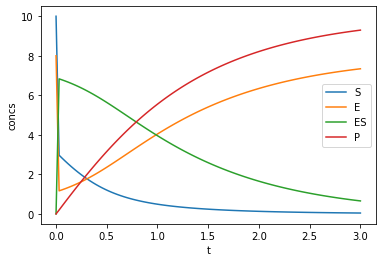

In [10]:
# Solve ODEs 
from TXOsim.models import michaelis

y0 = np.array([float(value) for value in speciesValues])
params = np.array([float(value) for value in parameterValues])
TMAX = 3
NSTEPS = 100
time = np.linspace(0,TMAX,NSTEPS)

sol = odeint(michaelis.model, y0, time, args=(params,)) 

# Plot and save plot
for i in range(sol.shape[1]):
    plt.plot(time,sol[:,i], label=speciesIds[i]);
plt.xlabel('t'); plt.ylabel('concs'); plt.legend()   
plt.savefig(PATH_TO_OUTPUT+'plot.pdf',transparent=True)
plt.show() 

# Save data
df = pd.DataFrame(sol)
df.to_csv(PATH_TO_OUTPUT+FILENAME, index=None)

## 4. Inference

If we have some experimental data, how do we fit the parameters to the model? Another workshop needed for this... but briefly:

In [11]:
from scipy.optimize import minimize

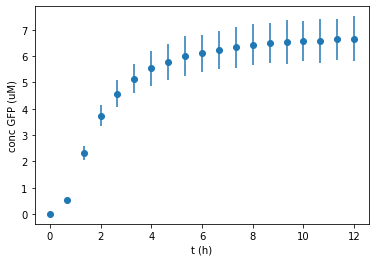

In [12]:
df=pd.read_csv("./reference/example_datafiles/dataexpt.csv")
df2=pd.read_csv("./reference/example_datafiles/errexpt.csv")
xfull = np.linspace(0,12,361)
yfull = df.iloc[:,0]
yerrfull = df2.iloc[:,0]
x = xfull[::20]
y = yfull[::20]
yerr = yerrfull[::20]
plt.errorbar(x,y,yerr=yerr,fmt='o'); plt.xlabel('t (h)'); plt.ylabel('conc GFP (uM)'); plt.show()

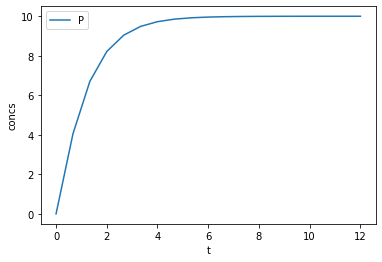

In [15]:
y0 = np.array([10,8,0,0])
params = np.array([100,50,1])
TMAX = 12
NSTEPS = 19
time = np.linspace(0,TMAX,NSTEPS)

sol = odeint(michaelis.model, y0, time, args=(params,),mxstep=10000) 

# Plot and save plot

plt.plot(time,sol[:,3], label=speciesIds[3]);
plt.xlabel('t'); plt.ylabel('concs'); plt.legend()   
plt.show() 

Define a function which measures the **distance** between model and data, and try to minimise that distance.

In [17]:
def log_likelihood(theta, x, y, yerr):
    k1,k2,k3,n1,n2 = theta
    params = np.array([k1,k2,k3])
    y0 = np.array([10*n1,8*n2,0,0])
    sol = odeint(michaelis.model, y0, time, args=(params,),mxstep=10000) 
    modelpred = sol[:,3]
    sigma2 = yerr ** 2 
    return -0.5 * np.sum((y - modelpred) ** 2 / sigma2 + np.log(sigma2))

In [18]:
np.random.seed(9)
nll = lambda *args: -log_likelihood(*args)
initial = np.array([100,50,1,1,1]) + 0.1 * np.random.randn(5)
soln = minimize(nll, initial, args=(x, y, yerr),options={'gtol': 1e-6, 'disp': True}) # Run minimizer
k1ml,k2ml,k3ml,n1ml,n2ml = soln.x
print('Best-fit parameters:', soln.x)

/home/jovyan/TXOsim/models/michaelis.py:17: RuntimeWarning:

overflow encountered in double_scalars

/home/jovyan/TXOsim/models/michaelis.py:18: RuntimeWarning:

overflow encountered in double_scalars

/home/jovyan/TXOsim/models/michaelis.py:19: RuntimeWarning:

overflow encountered in double_scalars

/home/jovyan/TXOsim/models/michaelis.py:17: RuntimeWarning:

invalid value encountered in double_scalars

/home/jovyan/TXOsim/models/michaelis.py:18: RuntimeWarning:

invalid value encountered in double_scalars

/home/jovyan/TXOsim/models/michaelis.py:19: RuntimeWarning:

invalid value encountered in double_scalars



         Current function value: 12.728313
         Iterations: 17
         Function evaluations: 437
         Gradient evaluations: 71
Best-fit parameters: [100.63111808  49.49554376   0.40512577   0.73709157   0.46063622]


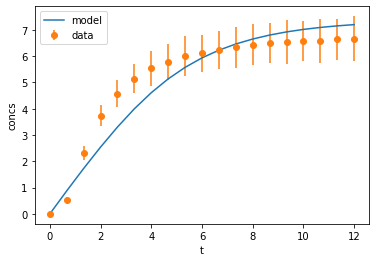

In [19]:
y0 = np.array([10*n1ml,8*n2ml,0,0])
params= np.array([k1ml,k2ml,k3ml])
TMAX = 12
NSTEPS = 19
time = np.linspace(0,TMAX,NSTEPS)

sol = odeint(michaelis.model, y0, time, args=(params,),mxstep=10000) 

# Plot and save plot

plt.plot(time,sol[:,3], label='model');
plt.errorbar(x,y,yerr=yerr, fmt='o',label='data')
plt.xlabel('t'); plt.ylabel('concs'); plt.legend(); plt.show()

This method does not always converge, multiple different parameter values may lead to similar fits, there is no estimate of error in the fit. So in general we prefer Bayesian methods for fitting, using a package like [emcee](https://emcee.readthedocs.io/en/stable/).